In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import randint
import DiscreteCondEnt as DC

In [77]:
from sklearn.metrics import mean_squared_error
def MSEscorer(clf, X, y):
    y_est = clf.predict(X)
    return mean_squared_error(y, y_est)

In [78]:
def varEntropy(y):
    return np.var(y)

In [79]:
from sklearn.linear_model import LinearRegression
linReg = LinearRegression()

In [80]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,1],[1,1]],
                                 size = 300)
x = np.transpose(x)

In [81]:
RVszie = 300
numRV =2
DEntropy = DC.computeEnt(x, linReg, logMSEscorer, varEntropy, CVFold)

2  Discrete RVs with range [ -2.285202297357644 ,  3.8053815305467564 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 1.159307166681144e-31
1 	 [0] 	 6.580202714961447e-32


In [82]:
x2 = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)
x2 = np.transpose(x2)

In [83]:
RVszie = 300
numRV =2
DEntropy2 = DC.computeEnt(x2, linReg, logMSEscorer, varEntropy, CVFold)

2  Discrete RVs with range [ -3.0802554368578043 ,  2.8818365071350898 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 1.0649172017845805
1 	 [0] 	 0.9814747401017968


In [84]:
DEntropy

array([[9.92152864e-01, 1.15930717e-31],
       [9.92152864e-01, 6.58020271e-32]])

In [85]:
#MI
MI12_1 = DEntropy[0,0] - DEntropy[0,1]
MI12_2 = DEntropy[1,0] - DEntropy[1,1]
print (MI12_1, MI12_2)

0.9921528638802749 0.9921528638802746


In [86]:
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim

def build_cov_matrix(rho):
    return torch.tensor([
        [1, 0, 0, rho],
        [0, 1, rho, 0],
        [0, rho, 1, 0],
        [rho, 0, 0, 1]]
    ).float()


lr = 0.001
last_lr = 0.000001
batch_size = 128
total_iters = 2000
display_step = 400


def mi_theta(T, pos, neg):
    return T(pos).mean() - T(neg).exp().mean().log()

MINE = []
LinReg = []
GT = []
COV = []

In [87]:
for i in range(19):
    cov = 0.1*i - 0.9
    COV.append(cov)
    #MINE=========================================================
    cov_matrix = build_cov_matrix(cov)
    X_ab = dist.MultivariateNormal(torch.zeros(4), cov_matrix)
    X_b = dist.MultivariateNormal(torch.zeros(2), cov_matrix[2:, 2:])

    # network
    T = nn.Sequential(
        nn.Linear(4, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )

    plot_loss = []
    trainer = optim.SGD(T.parameters(), lr=lr, momentum=0.9)

    #print('==================rho:%.2f=================' % cov)
    for it in range(total_iters):
        xab_samples = X_ab.sample((batch_size,))
        xb_samples = X_b.sample((batch_size,))
        neg_samples = torch.cat([xab_samples[:, :2], xb_samples], -1)

        loss = - mi_theta(T, xab_samples, neg_samples)
        trainer.zero_grad()
        loss.backward()
        trainer.step()
        plot_loss.append(loss.item())

        update_lr = lr - (lr - last_lr) * display_step / total_iters
        for param_group in trainer.param_groups:
            param_group['lr'] = update_lr

        #if (it + 1) % display_step == 0:
            #print('[Iter: %d] [loss: %.3f]' % (it, sum(plot_loss[-display_step:]) / display_step))

    xab_test_samples = X_ab.sample((1000,))
    xb_test_samples = X_b.sample((1000,))
    neg_test_samples = torch.cat([xab_test_samples[:, :2], xb_test_samples], -1)
    mi = mi_theta(T, xab_test_samples, neg_test_samples).mean().item()
    MINE.append(mi)
    #print('===================mi:%.2f=================' % mi)
    #plt.scatter(cov, mi, c='b', label='MINE')
    #MINE=========================================================
    x = np.transpose(np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,cov],[cov,1]],
                                 size = 10000))
    DE = DC.computeEnt(x, linReg, MSEscorer, varEntropy, CVFold)
    MI = DE[1,0] + DE[0,0] - DE[0,1] - DE[1,1]
    MI = MI/2
    LinReg.append(MI)
    #plt.scatter(cov, MI, c='g',label='KNN-regressor')
    groundTruth = -0.5*np.log(1-cov*cov)
    GT.append(groundTruth)
    #plt.scatter(cov, groundTruth, c='r',label='ground truth')

#plt.legend()
#plt.show()

2  Discrete RVs with range [ -4.295517855602024 ,  3.4741747959258964 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 0.18905277992763977
1 	 [0] 	 0.18978995514161487
2  Discrete RVs with range [ -3.749067999588906 ,  4.021720492858623 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 0.35199562054947586
1 	 [0] 	 0.3535186835253832
2  Discrete RVs with range [ -3.9747709749394553 ,  3.6328885364871457 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 0.5024588214613538
1 	 [0] 	 0.5089344080032127
2  Discrete RVs with range [ -3.9602411509548126 ,  3.786841978718815 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 0.6450073220076162
1 	 [0] 	 0.64702725179651
2  Discrete RVs with range [ -4.004625821167195 ,  4.0228004836462405 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 0.751937582781737
1 	 [0] 	 0.7395331985130746
2  Discrete RVs with range [ -3.8540767166893777 ,  3.8477848907990415 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 0.8410736457739643
1 	 [0] 	 0.8396121635007718
2  Discrete RVs with range [ -5.048153337979251 ,  4.74426224152466 ]
Resp	Cond	H

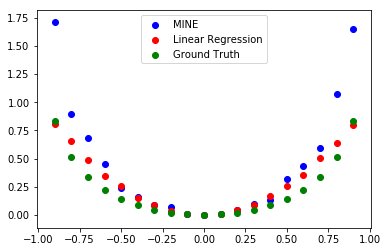

In [88]:
fig, ax = plt.subplots()

ax.scatter(COV, MINE, c='b', label='MINE')
ax.scatter(COV, KNN, c='r', label='Linear Regression')
ax.scatter(COV, GT, c='g', label='Ground Truth')

ax.legend()
plt.show()